## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [7]:
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [8]:
control_new=df.query("group=='control' and landing_page=='new_page'").count()[0]
treatment_old=df.query("group=='treatment' and landing_page=='old_page'").count()[0]
diffs_mismatch = treatment_old+control_new
diffs_mismatch                                                                                 

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2=df.copy()
df2.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
df2.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated(keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates('user_id', inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.unique()

array([0, 1], dtype=int64)

In [17]:
df2.converted.mean()*100

11.959708724499627

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [21]:
df2.query("landing_page=='new_page'").count()[0]/df2.shape[0]

0.5000619442226688

In [22]:
df2.query("landing_page=='old_page'").count()[0]/df2.shape[0]

0.4999380557773312

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**For group control and treatment has equal probilablity of ~12%. Individual landing to old page to new page has same proportion.We can confirm for same by the probabilty that an individual received the new page is 50% same as for old page. Therefore there is no strong evidence to consider that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$Null$ $Hypothesis$  $H_{0}$ : $p_{new}$ $-$ $p_{old}$ $<= 0$**

**$Alternative$ $Hypothesis$ $H_{1}$ : $p_{new}$ $-$ $p_{old}$ $> 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p_new=df2.query("group=='treatment'")['converted'].mean()
p_new

0.11880806551510564

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old=df2.query("group=='control'")['converted'].mean()
p_old

0.1203863045004612

c. What is $n_{new}$?

In [25]:
n_new=df2.query("group=='treatment'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old=df2.query("group=='control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted= np.random.choice([0,1], size=n_new,p=[(1-p_new),p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted= np.random.choice([0,1], size=n_old,p=[(1-p_old),p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean()-old_page_converted.mean()

-0.0018052509873186795

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new,p=[df.converted.mean(),(1-df.converted.mean())]).mean()
    old_page_converted = np.random.choice([0,1], size=n_old,p=[df.converted.mean(),(1-df.converted.mean())]).mean()
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [31]:
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [32]:
obs_diff=p_new-p_old
obs_diff

-0.0015782389853555567

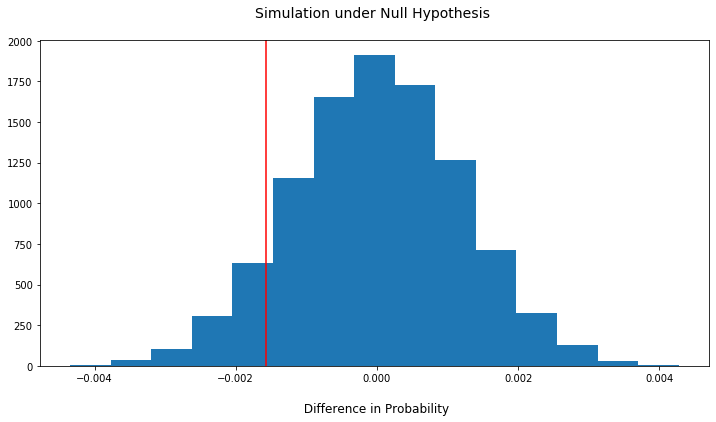

In [33]:
plt.figure(figsize=(12,6))
plt.hist(p_diffs, bins=15)
plt.title("Simulation under Null Hypothesis \n", fontsize=14)
plt.xlabel("\n Difference in Probability", fontsize=12)
plt.axvline(obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(p_diffs > obs_diff).mean()

0.9062

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The proportion of the p_diffs that are greater than the actual difference observed.**

**A p-value is the probability of observing your statistic if the null hypothesis is true.**

**As we stated before,null hypothesis as difference less than or equal to zero, and the alternative as the difference would be greater than 0. However, the difference is less than zero, and the p-value is very large and we can conclude that there is no statistical evidence to reject the null hypothesis. Therefore we fail to reject null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old =df2.query('group == "control"').converted.sum() 
convert_new =df2.query('group == "treatment"').converted.sum() 
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z score is a test of statistical significance that helps deciding whether or not to reject the null hypothesis. Resulted z_score is of 1.31. Since this value does not exceed the critical value at 95% confidence interval (1.96); there is no statistical evidence to reject the null hypothesis. Furthermore, p-value obtained is similar to the result obtained from our previous findings in j. and k. which also fails to reject the null hypothesis as it provides evidence of a higher probability of the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The essential difference between two types of regression is that Logistic regression is used when the dependent variable is binary in nature where as Linear regression is used when the dependent variable is continuousin nature. Since each row is either a conversion or no conversion, i.e binary in nature, Logistic regeresion model would do best fit model better than linear regresion.
Therefore fitting model with logisitic regression in predicting probablity for coversion or no conversion.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [38]:
df2['intercept']=1
df2[['ab_page']] = pd.get_dummies(df2['group'],drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result=log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:33:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.190**

**In Part II, the p-value was calculated where the null hypothesis was that the new page would convert more than the old page, and the alternative was the old page converted more than or equal to the new page.**

**In Part III, we used variables, and used a linear model to determine the p-value. The null hypothesis was that the difference between the pages is equal to 0, and the alternative hypothesis was the difference between the pages is greater or less than 0.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes it would be good, while considering other factors to add into the regression model which increase the learning rate for model in predicting outcome. Perhaps time of day that the user used the page, might influence when people sign up online. The disadvantage for adding addition terms would be like making model more complex and also due to multicollinearity.** 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
### Create the necessary dummy variables
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
df_new[['UK','US']]=pd.get_dummies(df_new['country'], drop_first=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [44]:
df_new[df_new['country']=='CA'].head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
813256,CA,2017-01-24 12:31:10.716026,treatment,new_page,0,1,1,0,0
942405,CA,2017-01-04 07:29:26.341719,treatment,new_page,0,1,1,0,0


In [45]:
### Fit Your Linear Model And Obtain the Results
log_model = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK', 'US']])
result = log_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:33:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**The p-values for the countries are also above a 0.05 $\alpha$ level. And so we fail to reject the null and conclude that on it's own, there is no significant contribution from country to differences in conversion rates for the two pages.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [47]:
log_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
result = log_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 16 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:33:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**The new feature created for interaction between page and country also has p-values above a 0.05 $\alpha$ level. Therefore there no significant effects on conversion.**

In [48]:
# Checking with timestamp

In [49]:
df_new['timestamp']=pd.to_datetime(df_new['timestamp'])
df_new['Day']=df_new['timestamp'].dt.day
df_new['Month']=df_new['timestamp'].dt.month
df_new['Year']=df_new['timestamp'].dt.year
df_new['Hour']=df_new['timestamp'].dt.hour
df_new['Weekday']=df_new['timestamp'].dt.weekday
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page,Day,Month,Year,Hour,Weekday
user_id,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0,14,1,2017,23,5
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1,23,1,2017,14,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0,16,1,2017,14,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0,22,1,2017,3,6
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0,16,1,2017,13,0


In [50]:
np.sort(df_new['Day'].unique())

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24], dtype=int64)

In [51]:
df_new['Month'].unique()

array([1], dtype=int64)

In [52]:
df_new['Year'].unique()

array([2017], dtype=int64)

In [53]:
df_new['Hour'].unique()

array([23, 14,  3, 13, 20, 18,  9, 11,  5,  4, 22, 16, 10, 21,  7, 12,  8,
        2, 15,  0, 19,  1,  6, 17], dtype=int64)

In [54]:
log_model_2= sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK', 'US','Day','Weekday','Hour']])
result = log_model_2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Sat, 16 May 2020   Pseudo R-squ.:               7.622e-05
Time:                        19:33:57   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01263
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0669      0.032    -65.156      0.000      -2.129      -2.005
ab_page       -0.0149      0.011     -1.301      0.193      -0.037       0.008
UK             0.0507      0.028      1.784      0.074      -0.005       0.106
US             0.0405      0.027      1.507      0.132      -0.012       0.093
Day            0.0016      0.001      1.729      0.084      -0.000       0.003
Weekday       -0.0034      0.003     -1.214      0.225      -0.009       0.002
Hour           0.0023      0.001      2.770      0.006       0.001       0.004
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

**None of the variables have significant p-values except for variable 'hour'. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.**

**In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.**

## Limitations
**Due to insufficient size of data it is very often responsible for poor performances of learning,and to extract the significant information for inferences is a critical issue. Here in our case, data consists for very short period i.e. for January 2017 only, making it insufficient for variables to predict the users to convert or not. If considering for longer window period range for study, it would make it easy and appropriate for predicting possible outcome for users geting converted or not converted.** 

